# Potholes Detection System

The goal of the project is creating a Deep Learning model that can be used to detect potholes in a street. Because of the dataset nature, the detection task is treated as a classification problem: the DL model is trained to classify photos of streets depending on whether they contain a pothole or not.

# Libraries and Reproducibility

We will begin by importing some useful libraries. Others will be imported later.

In [56]:
import numpy as np # linear algebra
import os # operating system

We will set a seed in order to improve this experiment's reproducibility. This will reduce the randomness, but does not guarantee the same results across various training processes. If you would like to achieve that, here you can find the necessary information: [Reproducibility in Keras Models](http://https://keras.io/examples/keras_recipes/reproducibility_recipes/).

In [57]:
from keras.utils import set_random_seed
set_random_seed(812)

# Data Exploration

The data is split into normal images and images with potholes. Let's load some of them with cv2 and visualize them with matplotlib.

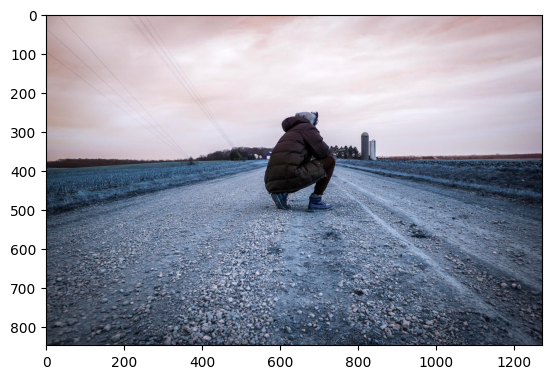

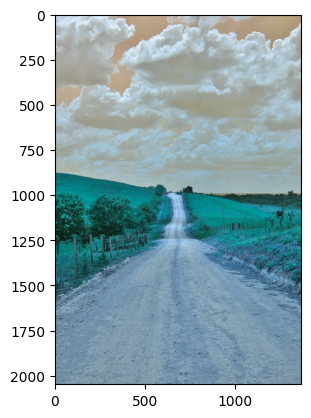

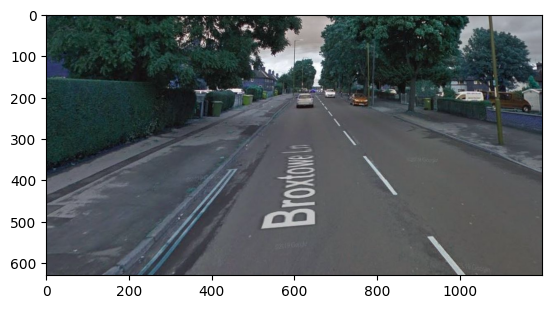

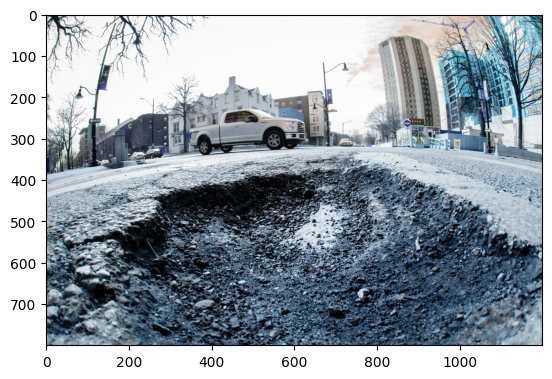

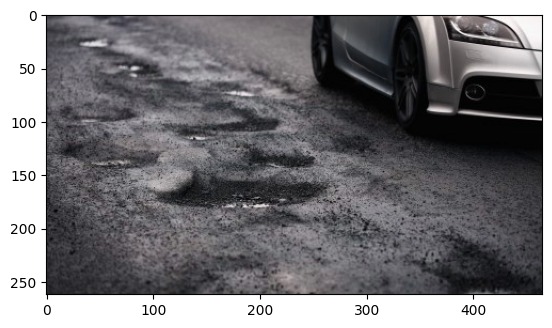

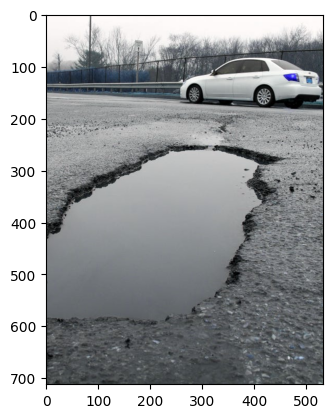

In [58]:
import cv2
import matplotlib.pyplot as plt

def explore_dir(dir_path, count):
    for _, _, filenames in os.walk(dir_path):
        for i in range(count):
            img = cv2.imread(os.path.join(dir_path, filenames[i]))
            plt.imshow(img)
            plt.show()

normal_dir = '/kaggle/input/pothole-detection-dataset/normal'
potholes_dir = '/kaggle/input/pothole-detection-dataset/potholes'

explore_dir(normal_dir, 3)
explore_dir(potholes_dir, 3)

Let's make sure the dataset is well-balanced by counting the number of pictures in each directory.

In [59]:
def count_files(dir_path):
    file_count = 0
    for _, _, filenames in os.walk(dir_path):
        file_count += len(filenames)
    return file_count

print('Normal images: ', count_files(normal_dir))
print('Potholes images: ', count_files(potholes_dir))

Normal images:  352
Potholes images:  329


# Data Pre-processing and Augmentation

Let's group all the images in a single dataset X. Normal images will be assigned the label Y = 0; whereas images with potholes will be assigned Y = 1.
While we are at it, let's normalize the images to have the same 150x150 size.

In [60]:
desired_size = (150, 150)
X, Y = [], []

def add_images(dir_path, label):
    for _, _, filenames in os.walk(dir_path):
        for file in filenames:
            try:
                img = cv2.imread(os.path.join(dir_path, file))
                img = cv2.resize(img, desired_size)
                X.append(np.array(img))
                Y.append(label)
            except:
                print('Image ' + os.path.join(dir_path, file) + ' could not be resized')
        
add_images(normal_dir, 0)
add_images(potholes_dir, 1)

Image /kaggle/input/pothole-detection-dataset/normal/226.jpg could not be resized


In [61]:
print(f"Dataset size: X = {len(X)}, Y = {len(Y)}")

Dataset size: X = 680, Y = 680


We will augment the dataset by flipping each image and adding the obtained image to the dataset.

In [62]:
import tensorflow as tf

img_count = len(X)
for i in range(img_count):
    flipped = tf.image.flip_left_right(X[i])
    X.append(flipped)
    Y.append(Y[i])
print(img_count)

680


Let's visualize some of the flipped images

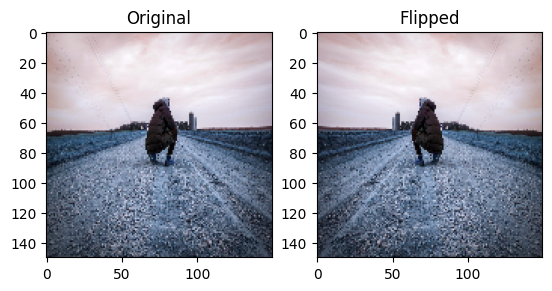

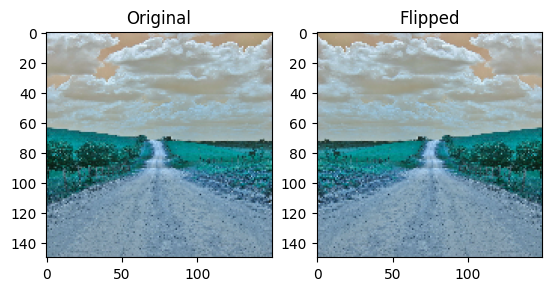

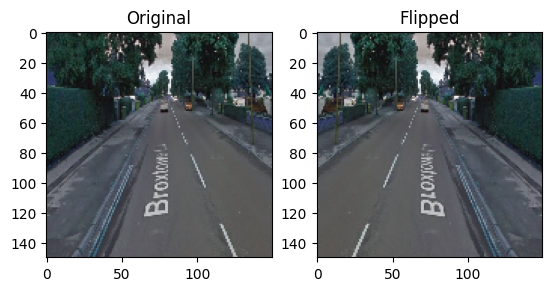

In [63]:
to_visualize = 3

for i in range(to_visualize):
    plt.subplot(1, 2, 1).imshow(X[i])
    plt.title('Original')
    plt.subplot(1, 2, 2).imshow(X[img_count + i])
    plt.title('Flipped')
    plt.show()

We need to encode the Y labels to be categorical variables.

In [64]:
from keras.utils import to_categorical

Y = to_categorical(Y,2)
print(Y)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


Let's split the dataset X into train and test with an 80/20 split.

In [65]:
from sklearn.model_selection import train_test_split

X = np.array(X)
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.20, random_state=5)

print(x_train.shape)
print(x_test.shape)

(1088, 150, 150, 3)
(272, 150, 150, 3)


# ANN Model

We will now create and train a Deep Neural Network. This will serve as a benchmark for evaluating the other models.

In [66]:
from tensorflow.keras import datasets, models
from tensorflow.keras.layers import Flatten, Dense, Dropout

ann = models.Sequential([
    Flatten(input_shape=(150, 150, 3)),
    Dense(100, activation='relu'),
    Dense(150, activation='relu'),
    Dense(150, activation='relu'),
    Dense(150, activation='relu'),
    Dense(100, activation='relu'),
    Dropout(0.15),
    Dense(2, activation = 'softmax')
])

In [67]:
# print model's architecture
ann.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 67500)             0         
                                                                 
 dense_19 (Dense)            (None, 100)               6750100   
                                                                 
 dense_20 (Dense)            (None, 150)               15150     
                                                                 
 dense_21 (Dense)            (None, 150)               22650     
                                                                 
 dense_22 (Dense)            (None, 150)               22650     
                                                                 
 dense_23 (Dense)            (None, 100)               15100     
                                                                 
 dropout_4 (Dropout)         (None, 100)              

Since this is a classification task, we will use the categorical cross-entropy as loss. We will also use an early-stopping callback so that we can interrupt the training process before overfitting, i.e. when the validation accuracy stops improving.

In [68]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

ann.compile(optimizer=Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

history = ann.fit(x_train, y_train, epochs=30, batch_size=32,
                    validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/30
34/34 [==============================] - 3s 58ms/step - loss: 379.8726 - accuracy: 0.5193 - val_loss: 44.2584 - val_accuracy: 0.7132
Epoch 2/30
34/34 [==============================] - 2s 51ms/step - loss: 76.1334 - accuracy: 0.5956 - val_loss: 6.1877 - val_accuracy: 0.7279
Epoch 3/30
34/34 [==============================] - 2s 50ms/step - loss: 14.2438 - accuracy: 0.6278 - val_loss: 13.2947 - val_accuracy: 0.5257
Epoch 4/30
34/34 [==============================] - 2s 51ms/step - loss: 5.3020 - accuracy: 0.6857 - val_loss: 1.6764 - val_accuracy: 0.7132
Epoch 5/30
34/34 [==============================] - 2s 54ms/step - loss: 3.1980 - accuracy: 0.6774 - val_loss: 3.4705 - val_accuracy: 0.7169
Epoch 6/30
34/34 [==============================] - 2s 51ms/step - loss: 1.2805 - accuracy: 0.7601 - val_loss: 0.5856 - val_accuracy: 0.8015
Epoch 7/30
34/34 [==============================] - 2s 54ms/step - loss: 0.5560 - accuracy: 0.8061 - val_loss: 0.4659 - val_accuracy: 0.8235
Epoch 8

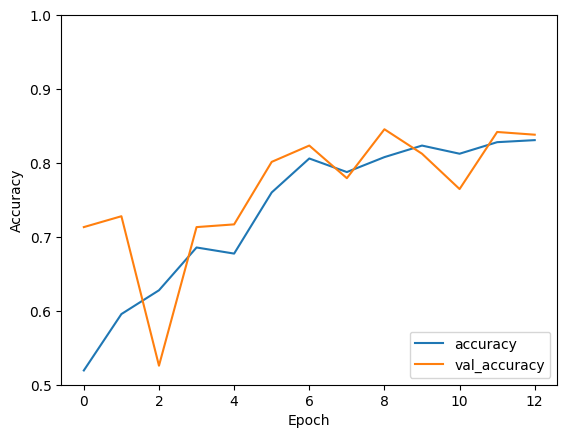

In [69]:
# plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [70]:
# print the achieved accuracy
ann_test_loss, ann_test_acc = ann.evaluate(x_test, y_test, verbose=2)
print('Best accuracy: ', ann_test_acc)

9/9 - 0s - loss: 0.4484 - accuracy: 0.8456 - 129ms/epoch - 14ms/step
Best accuracy:  0.845588207244873


# CNN Model

Let's now create a model that's better fit for tasks involving images. We will use a Convolutional Neural Network.

In [71]:
from tensorflow.keras import datasets, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D

cnn = models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.15),
    Dense(2, activation='softmax')
])

In [72]:
# print model's architecture
cnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_102 (Conv2D)         (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_103 (Conv2D)         (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_104 (Conv2D)         (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 17, 17, 128)      

As before, we will use categorical cross-entropy as loss and an early-stopping callback.

In [73]:
es = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

cnn.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = cnn.fit(x_train, y_train, epochs=20, batch_size=32,
                    validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/20
34/34 [==============================] - 30s 844ms/step - loss: 11.2686 - accuracy: 0.6259 - val_loss: 0.4883 - val_accuracy: 0.8162
Epoch 2/20
34/34 [==============================] - 28s 831ms/step - loss: 0.5820 - accuracy: 0.7289 - val_loss: 0.9771 - val_accuracy: 0.6103
Epoch 3/20
34/34 [==============================] - 28s 829ms/step - loss: 0.5882 - accuracy: 0.7105 - val_loss: 0.5439 - val_accuracy: 0.7574
Epoch 4/20
34/34 [==============================] - 28s 820ms/step - loss: 0.4857 - accuracy: 0.7978 - val_loss: 0.4171 - val_accuracy: 0.8419
Epoch 5/20
34/34 [==============================] - 28s 831ms/step - loss: 0.4121 - accuracy: 0.8171 - val_loss: 0.3959 - val_accuracy: 0.8088
Epoch 6/20
34/34 [==============================] - 28s 834ms/step - loss: 0.3229 - accuracy: 0.8676 - val_loss: 0.2529 - val_accuracy: 0.8860
Epoch 7/20
34/34 [==============================] - 28s 835ms/step - loss: 0.3596 - accuracy: 0.8447 - val_loss: 0.3886 - val_accuracy: 0.856

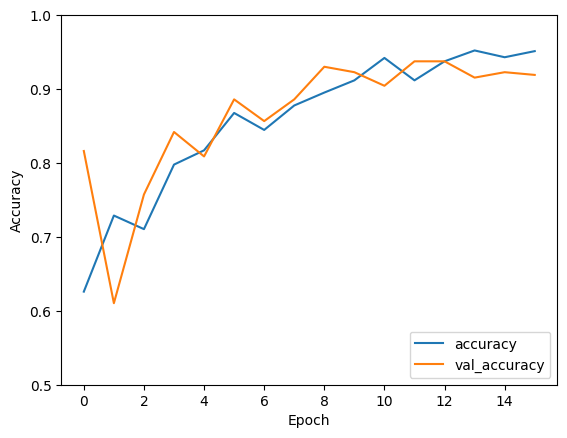

In [74]:
# plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [75]:
# print the achieved accuracy
cnn_test_loss, cnn_test_acc = cnn.evaluate(x_test,  y_test, verbose=2)
print('Best accuracy: ', cnn_test_acc)

9/9 - 2s - loss: 0.2168 - accuracy: 0.9375 - 2s/epoch - 212ms/step
Best accuracy:  0.9375


# InceptionV3

We will now try a different approach: instead of creating a model "from scratch", we will fine-tune a pre-trained model. We will specifically be using InceptionV3, which is a very powerful Convolutional Neural Network.

In order to fine-tune it we will do the following:
1. Load the base model without the top layer;
2. Add some layers to classify the input images based on the ouput of the base model;
3. Train only the added layers by freezing all the others.

Since InceptionV3 expects a specific type of input (pixels scaled between -1 and 1), we will need to preprocess our training and testing data.

The fine-tuning process described was adapted from this [guide](https://keras.io/api/applications/#usage-examples-for-image-classification-models) by Keras.

In [78]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D

# load the base model without the top layer: we will add ours for fine-tuning
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# create the model: we will add the necessary layers for our task on top of the base model
inception = models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(2, activation='softmax')
])


# we will only train the top layers, i.e. the ones we added
# thus, we need to freeze all the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

inception.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# pre-process the data to meet InceptionV3 requirements 
x_train_inception = preprocess_input(x_train)
x_test_inception = preprocess_input(x_test)

es = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# train the model on the new data for a few epochs
history = inception.fit(x_train_inception, y_train, epochs=20,
                    validation_data=(x_test_inception, y_test), callbacks=[es])

Epoch 1/20
34/34 [==============================] - 40s 1s/step - loss: 0.4387 - accuracy: 0.8309 - val_loss: 0.1702 - val_accuracy: 0.9412
Epoch 2/20
34/34 [==============================] - 32s 964ms/step - loss: 0.1157 - accuracy: 0.9605 - val_loss: 0.1207 - val_accuracy: 0.9522
Epoch 3/20
34/34 [==============================] - 32s 961ms/step - loss: 0.0528 - accuracy: 0.9789 - val_loss: 0.0915 - val_accuracy: 0.9669
Epoch 4/20
34/34 [==============================] - 32s 963ms/step - loss: 0.0185 - accuracy: 0.9954 - val_loss: 0.0938 - val_accuracy: 0.9743
Epoch 5/20
34/34 [==============================] - 32s 958ms/step - loss: 0.0091 - accuracy: 0.9982 - val_loss: 0.0816 - val_accuracy: 0.9706
Epoch 6/20
34/34 [==============================] - 32s 963ms/step - loss: 0.0060 - accuracy: 0.9991 - val_loss: 0.0747 - val_accuracy: 0.9779
Epoch 7/20
34/34 [==============================] - 32s 953ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0623 - val_accuracy: 0.9779
Ep

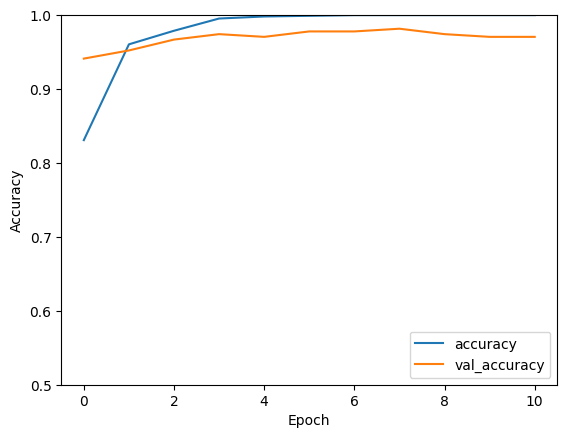

In [79]:
# plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [80]:
# print the achieved accuracy
inception_test_loss, inception_test_acc = inception.evaluate(x_test_inception,  y_test, verbose=2)
print('Best accuracy: ', inception_test_acc)

9/9 - 5s - loss: 0.0675 - accuracy: 0.9816 - 5s/epoch - 598ms/step
Best accuracy:  0.9816176295280457


# Models' Evaluation

Let's compare the accuracy of the models on the validation set.

In [85]:
print('ANN accuracy: ', ann_test_acc*100)
print('CNN accuracy: ', cnn_test_acc*100)
print('InceptionV3 accuracy: ', inception_test_acc*100)

ANN accuracy:  84.5588207244873
CNN accuracy:  93.75
InceptionV3 accuracy:  98.16176295280457


We will also analyse the AUC of the three models and plot their ROC curves.

The numpy function we will use for this expects the class labels to be integers. Since the models' outputs are in array form, we will need to convert them into integers. This is done by the following function.

In [82]:
# function to convert class labels from arrays to integers
def convert_to_single_value(multiple):
    binary = []
    for y in multiple:
        # the integer label is the same as the second element of the array label
        binary.append(y[1])
    return np.array(binary)

In [83]:
from sklearn.metrics import roc_curve, auc

# function to calculate AUC and plot ROC curve for a given model
def plot_auc(model, x_test, y_test, model_name):    
    # calculate predictions
    y_pred = model.predict(x_test)
    
    # convert to single value for AUC calculation
    y_pred = convert_to_single_value(y_pred)
    y_test = convert_to_single_value(y_test)
    
    # calculate and plot False Positve and True Positive rates
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    
    # print AUC
    roc_auc = auc(fpr, tpr)
    print(f'AUC of {model_name}: {roc_auc}')
    
    # plot ROC curve
    plt.plot(fpr, tpr, label=model_name)

9/9 [==============================] - 0s 12ms/step
AUC of ANN: 0.9043270276146989
9/9 [==============================] - 2s 216ms/step
AUC of CNN: 0.9758643183300717
9/9 [==============================] - 8s 594ms/step
AUC of InceptionV3: 0.9978799739073712


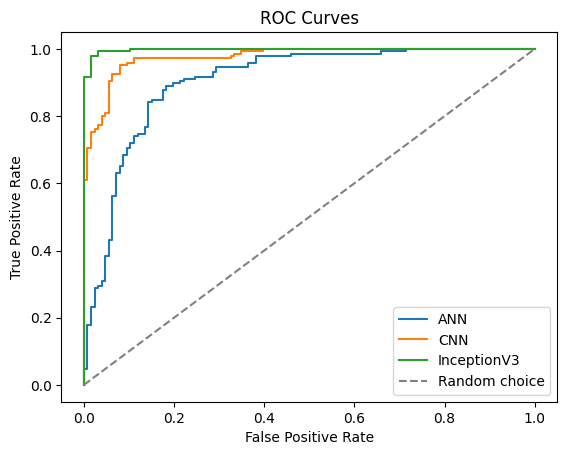

In [84]:
plot_auc(ann, x_test, y_test, 'ANN')
plot_auc(cnn, x_test, y_test, 'CNN')
plot_auc(inception, x_test_inception, y_test, 'InceptionV3')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random choice')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()